# House Price Predictions

In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings("ignore")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

Cleaning...

In [3]:
df.drop(columns='id', inplace=True)

In [4]:
cat_list = ['mssubclass','mszoning','street','alley','lotshape','landcontour','utilities','lotconfig','landslope','neighborhood','condition1','condition2',
            'bldgtype','housestyle','roofstyle','roofmatl','exterior1st','exterior2nd','masvnrtype','exterqual','extercond','foundation','bsmtqual','bsmtcond',
            'bsmtexposure','bsmtfintype1','bsmtfintype2','heating','heatingqc','centralair','electrical','kitchenqual','functional','fireplacequ','garagetype',
            'garagefinish','garagequal','garagecond','paveddrive','poolqc','fence','miscfeature','saletype','salecondition', 'overallqual', 'overallcond', 
            'yearbuilt', 'yearremodadd', 'mosold', 'yrsold']
for var in cat_list:
    df[var] = df[var].astype('category')

In [5]:
def add_cat_fillna(variable, new_cat='None'):
    df[variable] = df[variable].cat.add_categories(new_cat).fillna(new_cat).copy()

In [6]:
nulls_list = ['alley','bsmtqual','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfintype2','fireplacequ','garagetype','garagefinish','garagequal','garagecond',
             'poolqc','fence','miscfeature']
for var in nulls_list:
    add_cat_fillna(var)

In [7]:
df.masvnrtype = df.masvnrtype.fillna('None').copy()
df.masvnrarea = df.masvnrarea.fillna(0).copy()
df.lotfrontage = df.lotfrontage.fillna(df.lotfrontage.median()).copy()
df.electrical = df.electrical.fillna(df.electrical.mode()[0]).copy()
df.drop(columns='garageyrblt', inplace=True)

In [8]:
def outliers_std(data, columns, thresh=2):
    outlier_indexes = []
    for col in columns:
        ser_col = data[col]
        mean = ser_col.mean()
        sd = ser_col.std()
        outliers_mask = data[(data[col] > mean + thresh*sd) | (data[col] < mean - thresh*sd)].index
        outlier_indexes += [x for x in outliers_mask]
    return list(set(outlier_indexes))

In [9]:
df.drop(outliers_std(df, df.describe().columns), inplace=True)

Feature selection...

In [10]:
data = pd.DataFrame()
data['target'] = df.saleprice
data['totalsf'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
data['grlivarea'] = df.grlivarea
data['totalsf_grl_rel'] = (df.totalbsmtsf + df.firstflrsf + df.secondflrsf) * df.grlivarea
data['bedroomabvgr'] = df.bedroomabvgr
data['bedroomabvgr_sf_rel'] = df.bedroomabvgr * (df.totalbsmtsf + df.firstflrsf + df.secondflrsf)
data['garagearea'] = df.garagearea
data['selling_age'] = df.yrsold.astype('int') - df.yearbuilt.astype('int')
data = data.join(pd.get_dummies(df.mszoning, prefix='mszoning', drop_first=True))
data.drop(columns=['mszoning_RH', 'mszoning_RM'], inplace=True)

In [11]:
target = data['target'].copy()
X_data = data.iloc[:, 1:].copy()

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     197.2
Date:                Mon, 11 Nov 2019   Prob (F-statistic):          5.67e-145
Time:                        14:44:12   Log-Likelihood:                -4917.6
No. Observations:                 431   AIC:                             9855.
Df Residuals:                     421   BIC:                             9896.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5.852e+04    

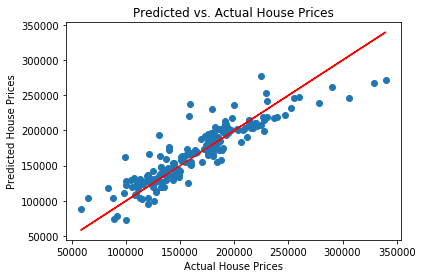

MAE: 14779.526784456493
MSE: 415993983.7957931
RMSE: 20395.930569498247
MAPE: 9.861378755602345


In [12]:
def do_it_all(X_data, target):
    X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=.3, random_state=12)
    
    X_train = sm.add_constant(X_train)
    results = sm.OLS(y_train, X_train).fit()
    print(results.summary())
    
    X_test = sm.add_constant(X_test)
    y_preds = results.predict(X_test)
    
    
    plt.scatter(y_test, y_preds)
    plt.plot(y_test, y_test, color='red')
    plt.xlabel('Actual House Prices')
    plt.ylabel('Predicted House Prices')
    plt.title('Predicted vs. Actual House Prices')
    plt.show()

    print(f'MAE: {mean_absolute_error(y_test, y_preds)}')
    print(f'MSE: {mse(y_test, y_preds)}')
    print(f'RMSE: {rmse(y_test, y_preds)}')
    print(f'MAPE: {np.mean(np.abs((y_test - y_preds)/y_test))*100}')
    
do_it_all(X_data, target)

The model looks pretty good, looks like it underestimates the price of some of the higher priced homes. There's still a decent amount of things that could probably be improved. Let's see if we can get some improvement.

In [13]:
data = pd.DataFrame()
data['target'] = df.saleprice
data['totalsf'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
data['totalsf_grl_rel'] = (df.totalbsmtsf + df.firstflrsf + df.secondflrsf) * df.grlivarea
data['bedroomabvgr'] = df.bedroomabvgr
data['bedroomabvgr_sf_rel'] = df.bedroomabvgr * (df.totalbsmtsf + df.firstflrsf + df.secondflrsf)
data['garagearea'] = df.garagearea
data['selling_age'] = df.yrsold.astype('int') - df.yearbuilt.astype('int')
data = data.join(pd.get_dummies(df.mszoning, prefix='mszoning', drop_first=True))
data.drop(columns=['mszoning_RH', 'mszoning_RM'], inplace=True)
data['overallqual'] = df.overallqual.astype(int)
data['overallcond'] = df.overallcond.astype(int)
data['sf_qual_rel'] = (df.totalbsmtsf + df.firstflrsf + df.secondflrsf) * df.overallqual.astype(int)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     248.5
Date:                Mon, 11 Nov 2019   Prob (F-statistic):          7.46e-176
Time:                        14:44:13   Log-Likelihood:                -4838.7
No. Observations:                 431   AIC:                             9701.
Df Residuals:                     419   BIC:                             9750.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                9.958e+04   3

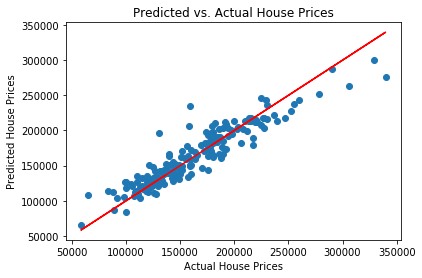

MAE: 12474.355374357438
MSE: 297005411.5949899
RMSE: 17233.844945194032
MAPE: 8.153114286751679


In [14]:
target2 = data['target']
X_data2 = data.iloc[:, 1:]
do_it_all(X_data2, target2)

After some tinkering, this looks pretty good actually! Looks like it's missing something to better predict higher priced houses though. What about mssubclass?

In [15]:
data = pd.DataFrame()
data['target'] = df.saleprice
data['totalsf'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
data['totalsf_grl_rel'] = (df.totalbsmtsf + df.firstflrsf + df.secondflrsf) * df.grlivarea
data['bedroomabvgr'] = df.bedroomabvgr
data['bedroomabvgr_sf_rel'] = df.bedroomabvgr * (df.totalbsmtsf + df.firstflrsf + df.secondflrsf)
data['garagearea'] = df.garagearea
data['selling_age'] = df.yrsold.astype('int') - df.yearbuilt.astype('int')
data = data.join(pd.get_dummies(df.mszoning, prefix='mszoning', drop_first=True))
data = data.join(pd.get_dummies(df.mssubclass, prefix='mssubclass', drop_first=True))
data.drop(columns=['mszoning_RH', 'mszoning_RM'], inplace=True)
data.drop(columns=['mssubclass_40', 'mssubclass_50', 'mssubclass_60', 'mssubclass_75', 'mssubclass_80', 'mssubclass_85', 'mssubclass_90',
                   'mssubclass_120', 'mssubclass_180', 'mssubclass_190', 'mssubclass_30', 'mssubclass_45'], inplace=True)
data['overallqual'] = df.overallqual.astype(int)
data['overallcond'] = df.overallcond.astype(int)
data['sf_qual_rel'] = (df.totalbsmtsf + df.firstflrsf + df.secondflrsf) * df.overallqual.astype(int)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     222.7
Date:                Mon, 11 Nov 2019   Prob (F-statistic):          2.38e-178
Time:                        14:44:14   Log-Likelihood:                -4827.0
No. Observations:                 431   AIC:                             9682.
Df Residuals:                     417   BIC:                             9739.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.158e+05   3

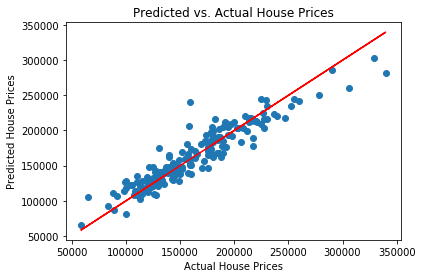

MAE: 12176.827366736465
MSE: 273365577.78924114
RMSE: 16533.770827891654
MAPE: 7.917380402260717


In [16]:
target3 = data['target']
X_data3 = data.iloc[:, 1:]
do_it_all(X_data3, target3)

The house that interests me the most is the one that was predicted to be nearly 250000, but in actuality was around 160000. Maybe it's just an outlier, this looks like a pretty good predictive model though.

In [17]:
data = pd.DataFrame()
data['target'] = df.saleprice
data['totalsf'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
data['totalsf_grl_rel'] = (df.totalbsmtsf + df.firstflrsf + df.secondflrsf) * df.grlivarea
data['bedroomabvgr'] = df.bedroomabvgr
data['bedroomabvgr_sf_rel'] = df.bedroomabvgr * (df.totalbsmtsf + df.firstflrsf + df.secondflrsf)
data['garagearea'] = df.garagearea
data['selling_age'] = df.yrsold.astype('int') - df.yearbuilt.astype('int')
data = data.join(pd.get_dummies(df.mszoning, prefix='mszoning', drop_first=True))
data = data.join(pd.get_dummies(df.mssubclass, prefix='mssubclass', drop_first=True))
data.drop(columns=['mszoning_RH', 'mszoning_RM'], inplace=True)
data.drop(columns=['mssubclass_40', 'mssubclass_50', 'mssubclass_60', 'mssubclass_75', 'mssubclass_80', 'mssubclass_85', 'mssubclass_90',
                   'mssubclass_120', 'mssubclass_180', 'mssubclass_190', 'mssubclass_30', 'mssubclass_45'], inplace=True)
data['overallqual'] = df.overallqual.astype(int)
data['overallcond'] = df.overallcond.astype(int)
data['sf_qual_rel'] = (df.totalbsmtsf + df.firstflrsf + df.secondflrsf) * df.overallqual.astype(int)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     190.2
Date:                Mon, 11 Nov 2019   Prob (F-statistic):          4.64e-166
Time:                        14:44:15   Log-Likelihood:                 317.57
No. Observations:                 431   AIC:                            -607.1
Df Residuals:                     417   BIC:                            -550.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.7389    

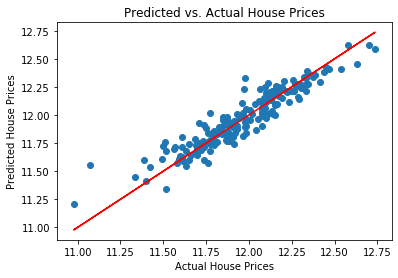

MAE: 0.07602480221162733
MSE: 0.010368261865917773
RMSE: 0.10182466236584226
MAPE: 0.6391907932772403


In [18]:
target4 = np.log1p(data['target'])
X_data4 = data.iloc[:, 1:]
do_it_all(X_data4, target4)

If we take the natural log of the target, then it has better predictive power for more expensive/mid range houses, but is not as good at detecting the low price houses.